#Instructions for using *fair*MARS in Google Colab:

 # Installation and Loading Packages:

1. Create a folder in your drive named "fairMARS".
2. Upload the 'py-earth' folder and your dataset (.csv) into the 'fairMARS' folder. For example, if you are using ELS.csv dataset, your fairMARS drive should ultimately include two items: the "py-earth" folder and the 'ELS.csv' file.

The two sample Datasets included are: "student-mat" and "ELS"

* ELS Dataset (Bozick, Lauff, and Wirt 2007):

 - This dataset consists of 970 instances with 40 predictor variables. A recommended sensitive attribute for fairness considerations is "pell_grant," a binary variable indicating the presence or absence of a Pell Grant. The response variable in this dataset is "GPA," representing the academic performance of the individuals.

* Student Performance Dataset (Cortez 2014):
 - This dataset consists of 395 instances and 33 predictor variables, focusing on student performance. For fairness considerations, we consider the binary variable "gender" as the sensitive attribute, with a binary classification. The response variable in this dataset is the final grade.


3. The code below mounts the Google Drive in Google Colab at the specified local directory ('./drive').

  ```python
  from google.colab import drive
  drive.mount('./drive')

*   Users may modify the argument to set a different mounting location within the Colab environment.
For example, to mount Google Drive at a directory named "custom_drive" within Colab, users can modify the code as follows:
drive.mount('./custom_drive')
*   After running this code block, you'll be prompted to click on a link, which will take you to a page where you can grant Colab permission to access your Google Drive.

4. Change the current working directory in Colab to the fairMARS code location:
  ```python
  %cd "drive/My Drive/fairMARS/py-earth"

5. Import essential libraries for fairMARS:
  ```python
  import pyearth
  from pyearth import Earth
  import numpy as np
  import pandas as pd


# Preprocessing Data for MARS/fairMARS

1. Convert all categorical variables to numerical representations. Categorical variables fall into two types: nominal and ordinal.

   1. **Nominal Variables:**
      - Nominal variables represent categories without any inherent order or ranking.
      - Examples: Colors, gender, race, types of fruits.
      - There is no meaningful sequence or hierarchy among categories.

   2. **Ordinal Variables:**
      - Ordinal variables have categories with a meaningful order or ranking.
      - Examples: Education levels (e.g., 'High School': 1, 'Bachelor's': 2, 'Master's': 3), satisfaction ratings (e.g., 'low': 1, 'medium' 2, high:'3').
      - The order between categories matters, but the intervals between them may not be uniform.

   For example, to convert a feature like "fruit" to numerical values, use a code command like:
   ```python
   # Example: Convert the 'fruit' feature to numerical values
   data['fruit'] = data['fruit'].map({'Apple': 1, 'Banana': 2, 'Orange': 3})


2. Ensure that categorical (nominal) variables are one-hot encoded.

* To create dummy variables for nominal variables, use the "get_dummies" function. Afterward, consider using the ".drop" function to eliminate one of the one-hot encoded categories. Dropping one category helps prevent multicollinearity since the absence of the dropped category can be inferred from the others. For example, if encoding fruit types, you might have {'Apple': 1, 'Banana': 2, 'Orange': 3}; in this case, drop 'Orange'.

   ```python
   # Creating dummy variables
   dummy_columns = pd.get_dummies(data['fruit'], prefix='fruit')
   # Concatenating dummy variables to the original DataFrame
   data = pd.concat([data, dummy_columns], axis=1)
   # Dropping one of the dummy variables to prevent multicollinearity
   data.drop('fruit_Orange', axis=1, inplace=True)

3. Separate the features and target variable:
  ```python
  # Assuming 'data' is your DataFrame, and 'GPA' is your target variable
  x = df.drop(columns={'GPA'}).copy()
  y = df.loc[:, 'GPA'].copy()

4. Split Data into Training and Testing Sets:
* Split your dataset into training and testing sets to evaluate the performance of the fairMARS model on unseen data. The training set is used to train the model, while the testing set evaluates its generalization ability. for example:
  ```python
  # Splitting the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=11)

5. Convert Training Data to Numpy Arrays:
  ```python
  # Convert training features and target variable to numpy arrays
  X_train_ = X_train.to_numpy()
  y_train_ = y_train.to_numpy()


# fairMARS: Configuring Parameters and Training

1. The fairMARS model introduces three additional arguments in the `model.fit` function to facilitate fairness adjustments within the algorithm:
  ```python
    model.fit(X_train, y_train, disparity_indices=[31], petha=0.2, fair_coef=True)

*   **disparity_indices (fairknot component):**

  This argument expects a list of column numbers corresponding to sensitive attributes in your dataset.
  *   Ensure proper one-hot encoding of sensitive attributes during preprocessing.
  *   In the ELS dataset, with binary values representing the protected attribute 'pell_grant', obtain the column number using:
    ```python
    x.columns.get_loc('pell_grant')
    ```

  <!-- In the ELS dataset, with binary values representing five protected attributes and column names 'Asian', 'Black', 'Hispanic', 'MR', 'White' obtain column numbers using:
    ```python
    x.columns.get_loc('Asian') -->

*  **petha (fairknot regularization parameter):**

  - This regularization parameter varies across datasets, influencing the model’s performance attributes.

  - For the original MARS algorithm developed by Friedman, `petha` value is set to 0.
  - In fairMARS, the `petha` value given to the argument should be greater than 0.
  - It must be tuned for each dataset to achieve fairness in the fairMARS model.

*  **fair_coef (faircoef component)::**

  A binary switch (True/False).
  When set to True, activates the fair coefficient component.


Additional MARS Parameter:

* **xlabels_` : list**
  - List of column names for training predictors.
  - Defaults to `['x0','x1',....]` if column names are not provided.
  - Including `xlabels` in your `model.fit` argument allows you to see feature names in the model summary.
```python
model.fit(X_train, y_train, disparity_indices=[31], petha=0.2, fair_coef=True, xlabels=x.columns.tolist())
```

* **Other parameters: ** For a comprehensive list of other MARS parameters, you can refer to the scikit-learn documentation at https://contrib.scikit-learn.org/py-earth/_modules/pyearth/earth.html





# fairMARS: Unfairness Definition

To assess the fairness of the MARS model, we employ the concept of "unfairness" measured through the Subgroup Error Difference. This metric measures the disparity in prediction errors among different subgroups defined by a sensitive attribute, such as gender.

Methodology:

1. **Error Calculation:**
    - Define the prediction error or loss function for the regression task. A common choice is the Residual Sum of Squares (RSS), measuring the squared difference between actual and predicted outcomes: $\text{RSS} = \sum_{i=1}^n (y_i - \hat{y}_i)^2$.

2. **Subgroup Division:**
    - Divide the dataset into subgroups based on the sensitive attribute. For example, for gender, create subgroups for males and females.

3. **Average RSS Calculation:**
    - Compute the average RSS for each subgroup:
      - $\text{RSS}_f = \frac{1}{n_f} \sum_{i=1}^{n_f} (y_i - \hat{y}_i)^2$ (for the female subgroup)
      - $\text{RSS}_m = \frac{1}{n_m} \sum_{i=1}^{n_m} (y_i - \hat{y}_i)^2$ (for the male subgroup)

4. **Error Difference Metric:**
    - Calculate the error difference metric by finding the absolute difference between the average RSS of each subgroup:
      - $|\text{RSS}_f - \text{RSS}_m|$ (for a scenario with two subgroups based on gender).

Interpretation:

The error difference metric serves as a quantifiable measure of the discrepancy in error between different subgroups resulting from the regression model. A lower error difference indicates a fairer model, where predictions are consistent across subgroups. Conversely, a higher error difference suggests a more biased model, with varying prediction accuracy between subgroups.

Goal:

Our objective is to minimize the average RSS difference, promoting demographic parity and ensuring fair and equal treatment for all subgroups. By minimizing this disparity, we aim to create a MARS model that provides accurate predictions across diverse demographic groups.


#MARS/FairMARS Execution

In [1]:
from google.colab import drive
drive.mount('./drive')

Mounted at ./drive


In [2]:
%cd "drive/My Drive/fairMARS/py-earth"

/content/drive/My Drive/fairMARS/py-earth


In [3]:
import pyearth
from pyearth import Earth
import numpy as np
import pandas as pd

In [4]:
df = pd.read_csv("../student-mat.csv", sep=';')
df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,...,5,5,4,4,5,4,11,9,9,9
391,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,3,14,16,16
392,MS,M,21,R,GT3,T,1,1,other,other,...,5,5,3,3,3,3,3,10,8,7
393,MS,M,18,R,LE3,T,3,2,services,other,...,4,4,1,3,4,5,0,11,12,10


In [ ]:
# @title Student Performance Dataset (MARS/FairMARS)


import io
import sys

# Define a dummy print function
def dummy_print(*args, **kwargs):
    pass

# Redirect standard output to the dummy print function
original_stdout = sys.stdout
sys.stdout = io.StringIO()


# Reading the Data:
df = pd.read_csv("../student-mat.csv", sep=';')

#data pre-processing:

data = pd.get_dummies(df, columns=['school','sex','address','famsize','Pstatus','Mjob','Fjob','reason','guardian','schoolsup','famsup','paid','activities','nursery','higher','internet','romantic'])
df = data.drop(columns={'sex_F','address_U','famsize_LE3','Pstatus_T','Mjob_teacher','Fjob_teacher','reason_reputation','guardian_other','schoolsup_no','famsup_no','paid_no','activities_no','nursery_no','higher_yes','internet_yes','romantic_yes'}).copy()
# Reorder the columns
df = df[['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2',
       'G3','school_MS',
      'Mjob_health', 'Mjob_other',
       'Mjob_services', 'Fjob_at_home', 'Fjob_health', 'Fjob_other',
       'Fjob_services', 'reason_course', 'reason_home', 'reason_other',
       'guardian_father', 'guardian_mother', 'schoolsup_yes', 'famsup_yes',
       'paid_yes', 'activities_yes', 'nursery_yes', 'higher_no', 'internet_no','school_GP','sex_M','address_R','famsize_GT3','Pstatus_A','Mjob_at_home',
       'romantic_no'
]]

#******************************Separating x and y:***********************************
x=df.drop(columns={'G3'}).copy()
y=df.loc[:,'G3'].copy()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

X_train_=X_train.to_numpy()
y_train_=y_train.to_numpy()


# Perform 10-fold cross-validation

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
# Define the list of petha (lambda) values
# petha = {0: "MARS", 3: "fairMARS"}
petha = [0,0.1,0.2,0.7,0.8,0.9,1,1.2,10,15,20,30,40]

# Initialize lists to store evaluation metrics
mae_test_results = []
mse_train_results = []
rsq_train_results = []
mse_test_results = []
rsq_test_results = []
mse_dif_gender_results = []


kf = KFold(n_splits=2, shuffle=True, random_state=123)
for i in petha:
    mae_test_fold = []
    mse_train_fold = []
    rsq_train_fold = []
    mse_test_fold = []
    rsq_test_fold = []
    mse_dif_gender_fold = []

    for train_index, test_index in kf.split(x):
        X_train_fold, X_test_fold = x.iloc[train_index], x.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        X_train_fold_ = X_train_fold.to_numpy()
        y_train_fold_ = y_train_fold.to_numpy()

        model = Earth(max_degree=1)
        model = model.fit(X_train_fold_, y_train_fold_, disparity_indices=[36], petha=i)

        mse_train_fold.append(model.mse_)
        rsq_train_fold.append(model.rsq_)

        y_hat_fold = model.predict(X_test_fold)
        df_x_test_fold = pd.DataFrame(X_test_fold, columns=X_test_fold.columns)
        df_x_test_fold.index = y_test_fold.index

        df_yyhat_fold = pd.concat([df_x_test_fold, y_test_fold.rename('y_test_actual')], axis=1)
        df_yyhat_fold['y_test_predicted'] = y_hat_fold

        rsq_test_fold_ = r2_score(df_yyhat_fold['y_test_actual'], df_yyhat_fold['y_test_predicted'])
        rsq_test_fold.append(rsq_test_fold_)

        mse_test_fold_ = mean_squared_error(df_yyhat_fold['y_test_actual'], df_yyhat_fold['y_test_predicted'])
        mse_test_fold.append(mse_test_fold_)

        df_yyhat_fold['MSE'] = np.power((df_yyhat_fold['y_test_actual'] - df_yyhat_fold['y_test_predicted']), 2)
        df_yyhat_fold.loc[df_yyhat_fold['sex_M']==1, 'sex'] = 'Female'
        df_yyhat_fold.loc[df_yyhat_fold['sex_M']==0, 'sex'] = 'Male'
        mse_gender_fold = df_yyhat_fold.loc[df_yyhat_fold['sex'] == 'Female', 'MSE'].mean()
        mse_others_fold = df_yyhat_fold.loc[df_yyhat_fold['sex'] != 'Female', 'MSE'].mean()
        mse_dif_gender_fold_ = abs(mse_others_fold - mse_gender_fold)
        mse_dif_gender_fold.append(mse_dif_gender_fold_)

    mae_test_results.append(np.mean(mae_test_fold))
    mse_train_results.append(np.mean(mse_train_fold))
    rsq_train_results.append(np.mean(rsq_train_fold))
    mse_test_results.append(np.mean(mse_test_fold))
    rsq_test_results.append(np.mean(rsq_test_fold))
    mse_dif_gender_results.append(np.mean(mse_dif_gender_fold))

fair_MARS_cv = pd.DataFrame([mse_train_results, rsq_train_results, mse_test_results, rsq_test_results, mse_dif_gender_results])
fair_MARS_cv.columns = petha
fair_MARS_cv.index = ['mse_train', 'rsq_train', 'mse_test', 'rsq_test', 'Unfairness']
# fair_MARS_cv.rename(index={0: "MARS", 3: "fairMARS"}, inplace=True)
# fair_MARS_cv.columns = fair_MARS_cv.columns.map(petha)
fair_MARS_cv

sys.stdout = original_stdout

In [45]:
fair_MARS_cv

,0.0,0.1,0.2,0.7,0.8,0.9,1.0,1.2,10.0,15.0,20.0,30.0,40.0
mse_train,3.238184,3.238184,3.312831,3.310075,3.310075,3.310075,3.334067,3.310075,3.517687,3.607054,3.607054,3.607054,3.607054
rsq_train,0.846100,0.846100,0.842352,0.842477,0.842477,0.842477,0.841273,0.842477,0.832906,0.828418,0.828418,0.828418,0.828418
mse_test,3.853324,3.853324,3.885830,3.880482,3.880482,3.880482,3.709129,3.880482,3.792053,3.811459,3.811459,3.811459,3.811459
rsq_test,0.816563,0.816563,0.815082,0.815350,0.815350,0.815350,0.823158,0.815350,0.818995,0.818111,0.818111,0.818111,0.818111
Unfairness,2.273358,2.273358,2.072886,2.078491,2.078491,2.078491,2.243390,2.078491,2.232078,1.999731,1.999731,1.999731,1.999731


In [ ]:
# @title ELS-Pell Dataset (MARS/FairMARS)


import io
import sys

# Define a dummy print function
def dummy_print(*args, **kwargs):
    pass

# Redirect standard output to the dummy print function
original_stdout = sys.stdout
sys.stdout = io.StringIO()

#*******************Reading Data************************************************

#ELS dataset preprocessing
data=pd.read_csv("../ELS.csv")

#*******************dropping the Race columns************************************************
data.drop(['Unnamed: 0','Asian', 'Black', 'Hispanic',
       'More_than_one', 'White'], inplace=True, axis=1)

# data=data.rename(columns={
#        'Race_Asian, Hawaii/Pac. Islander':'Asian', 'Race_Black or African American':'Black',
#        'Race_Hispanic':'Hispanic', 'Race_More than one race':'More_than_one', 'Race_White':'White'
# })

data = pd.get_dummies(data, columns=['F2_College entrance','School Urbanicity','Ins_attended'], prefix=['College_Ent','School_U','Ins_att'])
data.drop(['College_Ent_4.0','School_U_3','Ins_att_3.0'], inplace=True, axis=1)

# #***************************Remove NA*******************************************
df=data.dropna()

#Separating x and y:
x=df.drop(columns={'F3_GPA(all)'}).copy()
y=df.loc[:,'F3_GPA(all)'].copy()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

X_train_=X_train.to_numpy()
y_train_=y_train.to_numpy()

#*******************************************************************************
x.columns.get_loc('pell_grant')


# Perform 10-fold cross-validation

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

#****************** Define the list of petha (lambda) values ****************************
petha = [0,0.2]
# Initialize lists to store evaluation metrics
mae_test_results = []
mse_train_results = []
rsq_train_results = []
mse_test_results = []
rsq_test_results = []
mse_dif_pellgrant_results = []


kf = KFold(n_splits=5, shuffle=True, random_state=123)
for i in petha:
    mae_test_fold = []
    mse_train_fold = []
    rsq_train_fold = []
    mse_test_fold = []
    rsq_test_fold = []
    mse_dif_pellgrant_fold = []

    for train_index, test_index in kf.split(x):
        X_train_fold, X_test_fold = x.iloc[train_index], x.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        X_train_fold_ = X_train_fold.to_numpy()
        y_train_fold_ = y_train_fold.to_numpy()

        model = Earth(max_degree=1)
        model = model.fit(X_train_fold_, y_train_fold_, disparity_indices=[31], petha=i)

        mse_train_fold.append(model.mse_)
        rsq_train_fold.append(model.rsq_)

        y_hat_fold = model.predict(X_test_fold)
        df_x_test_fold = pd.DataFrame(X_test_fold, columns=X_test_fold.columns)
        df_x_test_fold.index = y_test_fold.index

        df_yyhat_fold = pd.concat([df_x_test_fold, y_test_fold.rename('y_test_actual')], axis=1)
        df_yyhat_fold['y_test_predicted'] = y_hat_fold

        rsq_test_fold_ = r2_score(df_yyhat_fold['y_test_actual'], df_yyhat_fold['y_test_predicted'])
        rsq_test_fold.append(rsq_test_fold_)

        mse_test_fold_ = mean_squared_error(df_yyhat_fold['y_test_actual'], df_yyhat_fold['y_test_predicted'])
        mse_test_fold.append(mse_test_fold_)

        df_yyhat_fold['MSE'] = np.power((df_yyhat_fold['y_test_actual'] - df_yyhat_fold['y_test_predicted']), 2)
        df_yyhat_fold.loc[df_yyhat_fold['pell_grant']==1, 'pell'] = 'R'
        df_yyhat_fold.loc[df_yyhat_fold['pell_grant']==0, 'pell'] = 'NR'
        mse_pellgrant_fold = df_yyhat_fold.loc[df_yyhat_fold['pell'] == 'R', 'MSE'].mean()
        mse_others_fold = df_yyhat_fold.loc[df_yyhat_fold['pell'] != 'R', 'MSE'].mean()
        mse_dif_pellgrant_fold_ = abs(mse_others_fold - mse_pellgrant_fold)
        mse_dif_pellgrant_fold.append(mse_dif_pellgrant_fold_)

    mae_test_results.append(np.mean(mae_test_fold))
    mse_train_results.append(np.mean(mse_train_fold))
    rsq_train_results.append(np.mean(rsq_train_fold))
    mse_test_results.append(np.mean(mse_test_fold))
    rsq_test_results.append(np.mean(rsq_test_fold))
    mse_dif_pellgrant_results.append(np.mean(mse_dif_pellgrant_fold))

fair_MARS_cv = pd.DataFrame([mse_train_results, rsq_train_results, mse_test_results, rsq_test_results, mse_dif_pellgrant_results])
fair_MARS_cv.columns = petha
fair_MARS_cv.index = ['mse_train', 'rsq_train', 'mse_test', 'rsq_test', 'Unfairness']
# fair_MARS_cv.rename(index={0: "MARS", 3: "fairMARS"}, inplace=True)
# fair_MARS_cv.columns = fair_MARS_cv.columns.map(petha)
fair_MARS_cv

# Reset standard output
sys.stdout = original_stdout

In [49]:
fair_MARS_cv

,0.0,0.2
mse_train,0.128852,0.130974
rsq_train,0.704241,0.699335
mse_test,0.139448,0.140641
rsq_test,0.674330,0.671835
Unfairness,0.043302,0.044918


In [50]:
# @title ELS-Pell Dataset (MARS/FairMARS) - Basis Functions

#*******************Reading Data************************************************

#ELS dataset preprocessing
data=pd.read_csv("../ELS.csv")

#*******************dropping the Race columns************************************************
data.drop(['Unnamed: 0','Asian', 'Black', 'Hispanic',
       'More_than_one', 'White'], inplace=True, axis=1)

# data=data.rename(columns={
#        'Race_Asian, Hawaii/Pac. Islander':'Asian', 'Race_Black or African American':'Black',
#        'Race_Hispanic':'Hispanic', 'Race_More than one race':'More_than_one', 'Race_White':'White'
# })

data = pd.get_dummies(data, columns=['F2_College entrance','School Urbanicity','Ins_attended'], prefix=['College_Ent','School_U','Ins_att'])
data.drop(['College_Ent_4.0','School_U_3','Ins_att_3.0'], inplace=True, axis=1)

# #***************************Remove NA*******************************************
df=data.dropna()

# #******************************#Separating x and y:***********************************

x=df.drop(columns={'F3_GPA(all)'}).copy()
y=df.loc[:,'F3_GPA(all)'].copy()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

X_train_=X_train.to_numpy()
y_train_=y_train.to_numpy()

# #*******************************************************************************
x.columns.get_loc('pell_grant')


#Original MARS results:
model = Earth(max_degree=1)

model = model.fit(X_train_, y_train_, disparity_indices=[31],petha=0, xlabels=X_train.columns.tolist())
print(model.summary())

/content/drive/My Drive/fairMARS/py-earth/pyearth/earth.py:820: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()


Earth Model
----------------------------------------------------
Basis Function                 Pruned  Coefficient  
----------------------------------------------------
(Intercept)                    No      1.35496      
F3_GPA(first year)             No      0.494828     
9_12_GPA                       No      0.14061      
F3_Highest level of education  No      0.284        
h(%Black teacher-52)           No      -0.0125763   
h(52-%Black teacher)           Yes     None         
Ins_att_1.0                    No      -0.761965    
h(Std Math/Reading-44.43)      Yes     None         
h(44.43-Std Math/Reading)      No      -0.0428871   
Ins_att_2.0                    No      -0.653666    
%Hispanic_NR teacher           Yes     None         
gender_Female                  Yes     None         
Marital_Par_Married            Yes     None         
h(%Hispanic_NR teacher-67)     No      0.0122703    
h(67-%Hispanic_NR teacher)     Yes     None         
English                        Yes

/content/drive/My Drive/fairMARS/py-earth/pyearth/earth.py:1128: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = linalg_mod.lstsq(B, weighted_y[:, i])[0:2]


In [ ]:
# @title ELS-Pell Dataset (MARS/FairMARS) - Basis Functions

#*******************Reading Data************************************************

#ELS dataset preprocessing
data=pd.read_csv("../ELS.csv")

#*******************dropping the Race columns************************************************
data.drop(['Unnamed: 0','Asian', 'Black', 'Hispanic',
       'More_than_one', 'White'], inplace=True, axis=1)

# data=data.rename(columns={
#        'Race_Asian, Hawaii/Pac. Islander':'Asian', 'Race_Black or African American':'Black',
#        'Race_Hispanic':'Hispanic', 'Race_More than one race':'More_than_one', 'Race_White':'White'
# })

data = pd.get_dummies(data, columns=['F2_College entrance','School Urbanicity','Ins_attended'], prefix=['College_Ent','School_U','Ins_att'])
data.drop(['College_Ent_4.0','School_U_3','Ins_att_3.0'], inplace=True, axis=1)

# #***************************Remove NA*******************************************
df=data.dropna()

# #******************************#Separating x and y:***********************************

x=df.drop(columns={'F3_GPA(all)'}).copy()
y=df.loc[:,'F3_GPA(all)'].copy()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

X_train_=X_train.to_numpy()
y_train_=y_train.to_numpy()

# #*******************************************************************************
x.columns.get_loc('pell_grant')


#Original MARS results:
model = Earth(max_degree=1)

model = model.fit(X_train_, y_train_, disparity_indices=[31],petha=0.2, xlabels=X_train.columns.tolist())
print(model.summary())

In [51]:
# @title ELS-Race Dataset(MARS/FairMARS) - Basis Functions
#*******************Reading Data************************************************

#ELS dataset preprocessing
data=pd.read_csv("../new2.csv")
data.drop(['Unnamed: 0'], inplace=True, axis=1)
#data.drop(['Unnamed: 0','gender_Male','Race_Amer. Indian/Alaska Native','F3_GPA(first year)','F3_Highest level of education','credits(first year)','F2_transferred','F2_grant'], inplace=True, axis=1)
data=data.rename(columns={
       'Race_Asian, Hawaii/Pac. Islander':'Asian', 'Race_Black or African American':'Black',
       'Race_Hispanic':'Hispanic', 'Race_More than one race':'More_than_one', 'Race_White':'White'
})

data = pd.get_dummies(data, columns=['F2_College entrance','School Urbanicity','Ins_attended'], prefix=['College_Ent','School_U','Ins_att'])
data.drop(['College_Ent_4.0','School_U_3','Ins_att_3.0'], inplace=True, axis=1)

# #***************************Remove NA*******************************************
df=data.dropna()

# #******************************Separating x and y:***********************************

x=df.drop(columns={'F3_GPA(all)'}).copy()
y=df.loc[:,'F3_GPA(all)'].copy()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)
#456 gives the best
#123=great

X_train_=X_train.to_numpy()
y_train_=y_train.to_numpy()

# #*******************************************************************************
x.columns.get_loc('Asian')

#Original MARS results:
model = Earth(max_degree=1)

model = model.fit(X_train_, y_train_, disparity_indices=[27,28,29,30,31],petha=0, xlabels=X_train.columns.tolist())
print(model.summary())

/content/drive/My Drive/fairMARS/py-earth/pyearth/earth.py:820: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()


Earth Model
----------------------------------------------------
Basis Function                 Pruned  Coefficient  
----------------------------------------------------
(Intercept)                    No      1.35496      
F3_GPA(first year)             No      0.494828     
9_12_GPA                       No      0.14061      
F3_Highest level of education  No      0.284        
h(%Black teacher-52)           No      -0.0125763   
h(52-%Black teacher)           Yes     None         
Ins_att_1.0                    No      -0.761965    
h(Std Math/Reading-44.43)      Yes     None         
h(44.43-Std Math/Reading)      No      -0.0428871   
Ins_att_2.0                    No      -0.653666    
%Hispanic_NR teacher           Yes     None         
gender_Female                  Yes     None         
Black                          Yes     None         
Marital_Par_Married            Yes     None         
English                        Yes     None         
athletic level                 Yes

/content/drive/My Drive/fairMARS/py-earth/pyearth/earth.py:1128: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = linalg_mod.lstsq(B, weighted_y[:, i])[0:2]


#Fair Linear Regression (FLR) Execution

In [ ]:
!pip install aif360
#Install aif360
#Install Reductions from Fairlearn
#Install Low School GPA dataset
!pip install aif360[Reductions]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.1/214.1 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.5/231.5 kB 4.1 MB/s eta 0:00:00


In [ ]:
pip install 'aif360[all]'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.1/214.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.6/133.6 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 86.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 91.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 90.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.5/231.5 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 24.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 96.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
import pandas as pd

from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from aif360.sklearn.inprocessing import GridSearchReduction
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold


In [ ]:
# @title Student Performance Dataset (FLR)
df = pd.read_csv("../student-mat.csv", sep=';')

#data pre-processing:

data = pd.get_dummies(df, columns=['school','sex','address','famsize','Pstatus','Mjob','Fjob','reason','guardian','schoolsup','famsup','paid','activities','nursery','higher','internet','romantic'])
df = data.drop(columns={'sex_F','address_U','famsize_LE3','Pstatus_T','Mjob_teacher','Fjob_teacher','reason_reputation','guardian_other','schoolsup_no','famsup_no','paid_no','activities_no','nursery_no','higher_yes','internet_yes','romantic_yes'}).copy()
# Reorder the columns
df = df[['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2',
       'G3','school_MS',
      'Mjob_health', 'Mjob_other',
       'Mjob_services', 'Fjob_at_home', 'Fjob_health', 'Fjob_other',
       'Fjob_services', 'reason_course', 'reason_home', 'reason_other',
       'guardian_father', 'guardian_mother', 'schoolsup_yes', 'famsup_yes',
       'paid_yes', 'activities_yes', 'nursery_yes', 'higher_no', 'internet_no','school_GP','sex_M','address_R','famsize_GT3','Pstatus_A','Mjob_at_home',
       'romantic_no'
]]

# #******************************Separating x and y:***********************************

x=df.drop(columns={'G3'}).copy()
y=df.loc[:,'G3'].copy()

# x['sex'] = x['sex_M']

# x['sex_M'] = x['sex_M'].astype(str)  # Ensure 'sex_M' is in string format for index
# x.set_index('sex_M', inplace=True)

# Verify the change in index
# print(x.index)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

from sklearn.model_selection import KFold
import numpy as np

# Define a 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=123)

mse_test_scores = []
mse_dif_gender_scores = []

for train_index, test_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    scaler = MinMaxScaler()
    estimator = TransformedTargetRegressor(LinearRegression(), transformer=scaler)
    grid_search_red = GridSearchReduction(prot_attr=["sex_M"],
                                          estimator=estimator,
                                          constraints="BoundedGroupLoss",
                                          loss="Square",
                                          min_val=y_train_fold.min(),
                                          max_val=y_train_fold.max(),
                                          grid_size=10,
                                          drop_prot_attr=True)

    grid_search_red.fit(X_train_fold, y_train_fold)
    gs_pred = grid_search_red.predict(X_val_fold)

    df_x_val_fold = pd.DataFrame(X_val_fold, columns=X_val_fold.columns)
    df_x_val_fold.index = y_val_fold.index

    df_yyhat_val_fold = pd.concat([df_x_val_fold, y_val_fold.rename('y_test_actual')], axis=1)
    df_yyhat_val_fold['y_test_predicted'] = gs_pred

    # Calculate MSE for the current fold
    mse_test_fold = mean_squared_error(df_yyhat_val_fold['y_test_actual'], df_yyhat_val_fold['y_test_predicted'])
    mse_test_scores.append(mse_test_fold)

    # Calculate mse_dif_gender for the current fold
    df_yyhat_val_fold['MSE'] = np.power((df_yyhat_val_fold['y_test_actual'] - df_yyhat_val_fold['y_test_predicted']), 2)
    df_yyhat_val_fold.loc[df_yyhat_val_fold['sex_M']==1, 'sex'] = 'Female'
    df_yyhat_val_fold.loc[df_yyhat_val_fold['sex_M']==0, 'sex'] = 'Male'
    mse_gender_fold = df_yyhat_val_fold.loc[df_yyhat_val_fold['sex'] == 'Female', 'MSE'].mean()
    mse_others_fold = df_yyhat_val_fold.loc[df_yyhat_val_fold['sex'] != 'Female', 'MSE'].mean()
    mse_dif_gender_fold = abs(mse_others_fold - mse_gender_fold)
    mse_dif_gender_scores.append(mse_dif_gender_fold)

# Calculate the average MSE for the test set
average_mse_test = np.mean(mse_test_scores)

# Calculate the average mse_dif_gender across all folds
average_mse_dif_gender = np.mean(mse_dif_gender_scores)

print(f"Average MSE for the test set across 10 folds: {average_mse_test}")
print(f"Average mse_dif_gender across 10 folds: {average_mse_dif_gender}")

Average MSE for the test set across 10 folds: 4.630874608628895
Average mse_dif_gender across 10 folds: 3.2335046849908813


In [ ]:
# @title ELS Dataset (FLR)

mse_test = []
mse_dif_asian = []
mse_dif_black = []
mse_dif_hispanic = []
mse_dif_MR = []
mse_dif_white = []

for j in range(1, 11):
    df_train_ = pd.read_csv('../py-earth/kfold/ELS/MARS/df_train_fold_' + str(j) + '.csv')
    df_train = df_train_.dropna()
    X_train_fold = df_train.drop(columns=['F3_GPA(all)']).copy()
    y_train_fold = df_train['F3_GPA(all)'].copy()

    df_test_ = pd.read_csv('../py-earth/kfold/ELS/MARS/df_test_fold_' + str(j) + '.csv')
    df_test = df_test_.dropna()
    X_test_fold = df_test.drop(columns=['F3_GPA(all)']).copy()
    y_test_fold = df_test['F3_GPA(all)'].copy()

    # Scale the columns in the train and test data
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()

    estimator = TransformedTargetRegressor(LinearRegression(), transformer=scaler)
    grid_search_red = GridSearchReduction(prot_attr=["Asian","Black","Hispanic","More_than_one","White"],
                                          estimator=estimator,
                                          constraints="BoundedGroupLoss",
                                          loss="Square",
                                          min_val=y_train_fold.min(),
                                          max_val=y_train_fold.max(),
                                          grid_size=200,
                                          drop_prot_attr=True)

    grid_search_red.fit(X_train_fold, y_train_fold)
    gs_pred = grid_search_red.predict(X_test_fold)

    df_X_test_fold = pd.DataFrame(X_test_fold, columns=X_test_fold.columns)
    df_X_test_fold.index = y_test_fold.index

    df_yyhat_test_fold = pd.concat([df_X_test_fold, y_test_fold.rename('y_test_actual')], axis=1)
    df_yyhat_test_fold['y_test_predicted'] = gs_pred

    mse_test_fold = mean_squared_error(df_yyhat_test_fold['y_test_actual'], df_yyhat_test_fold['y_test_predicted'])
    mse_test.append(mse_test_fold)

    df_yyhat_test_fold['MSE'] = (df_yyhat_test_fold['y_test_actual'] - df_yyhat_test_fold['y_test_predicted']) ** 2

    # Calculate subgroup differences for each race

    mse_dif_asian.append(abs(df_yyhat_test_fold.loc[df_yyhat_test_fold['Asian'] == 1, 'MSE'].mean() -
                              df_yyhat_test_fold.loc[df_yyhat_test_fold['Asian'] != 1, 'MSE'].mean()))

    mse_dif_black.append(abs(df_yyhat_test_fold.loc[df_yyhat_test_fold['Black'] == 1, 'MSE'].mean() -
                              df_yyhat_test_fold.loc[df_yyhat_test_fold['Black'] != 1, 'MSE'].mean()))

    mse_dif_hispanic.append(abs(df_yyhat_test_fold.loc[df_yyhat_test_fold['Hispanic'] == 1, 'MSE'].mean() -
                                df_yyhat_test_fold.loc[df_yyhat_test_fold['Hispanic'] != 1, 'MSE'].mean()))

    mse_dif_MR.append(abs(df_yyhat_test_fold.loc[df_yyhat_test_fold['More_than_one'] == 1, 'MSE'].mean() -
                          df_yyhat_test_fold.loc[df_yyhat_test_fold['More_than_one'] != 1, 'MSE'].mean()))

    mse_dif_white.append(abs(df_yyhat_test_fold.loc[df_yyhat_test_fold['White'] == 1, 'MSE'].mean() -
                              df_yyhat_test_fold.loc[df_yyhat_test_fold['White'] != 1, 'MSE'].mean()))

# Compute the mean of metrics for all folds
average_mse_test = np.mean(mse_test)
average_mse_dif_asian = np.mean(mse_dif_asian)
average_mse_dif_black = np.mean(mse_dif_black)
average_mse_dif_hispanic = np.mean(mse_dif_hispanic)
average_mse_dif_MR = np.mean(mse_dif_MR)
average_mse_dif_white = np.mean(mse_dif_white)

print(f"Average MSE for the test set across 10 folds: {average_mse_test}")
print(f"Average mse_dif_asian across 10 folds: {average_mse_dif_asian}")
print(f"Average mse_dif_black across 10 folds: {average_mse_dif_black}")
print(f"Average mse_dif_hispanic across 10 folds: {average_mse_dif_hispanic}")
print(f"Average mse_dif_MR across 10 folds: {average_mse_dif_MR}")
print(f"Average mse_dif_white across 10 folds: {average_mse_dif_white}")


#XGBClassifier

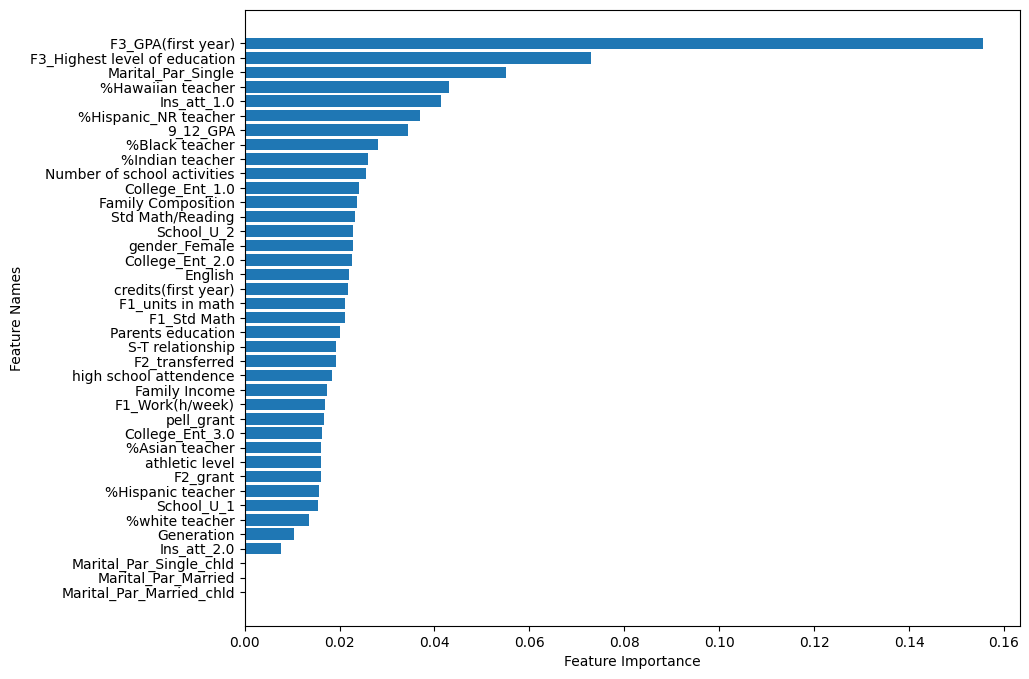

In [66]:
# Import necessary libraries
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import pandas as pd
from sklearn.model_selection import train_test_split

# ELS dataset preprocessing
data = pd.read_csv("../ELS.csv")

# *******************dropping the Race columns************************************************
data.drop(['Unnamed: 0', 'Asian', 'Black', 'Hispanic',
           'More_than_one', 'White'], inplace=True, axis=1)

data = pd.get_dummies(data, columns=['F2_College entrance', 'School Urbanicity', 'Ins_attended'],
                      prefix=['College_Ent', 'School_U', 'Ins_att'])
data.drop(['College_Ent_4.0', 'School_U_3', 'Ins_att_3.0'], inplace=True, axis=1)

# # ***************************Remove NA*******************************************
df = data.dropna()

# Separating x and y:
x = df.drop(columns={'F3_GPA(all)'}).copy()
y = df.loc[:, 'F3_GPA(all)'].copy()

# Convert floating-point classes to integers
y = y.astype(int)

# define the model
model = XGBClassifier()

# fit the model
model.fit(x, y)

# get importance
importance = model.feature_importances_

# Get the indices that would sort the feature importance scores
indices = importance.argsort()

# Set a larger plot size
plt.figure(figsize=(10, 8))

# Transpose the plot and print feature names based on their importance scores
plt.barh(range(len(indices)), importance[indices])
plt.yticks(range(len(indices)), x.columns[indices])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.show()
